# Abuse (4 types) × Dental Checkup Data: ML Analysis Notebook

This notebook provides:

1. Random Forest multiclass classification (Physical / Neglect / Emotional / Sexual)
2. Cross-validation metrics + confusion matrix
3. Permutation importance (by original columns)
4. FastICA on aggregated numeric dental indices + group comparison

**Notes**
- Tooth-level columns (e.g., U17, L36, u55...) are treated as **categorical codes** (one-hot) because code definitions are not provided.
- Free-text columns (e.g., instruction_detail, memo) are excluded by default to avoid leakage and improve reproducibility.


In [3]:

# ---- 0) Imports ----
import os
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# import shap

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    balanced_accuracy_score,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn.decomposition import FastICA

# Optional (for adjusted group comparisons of ICA scores)
try:
    import statsmodels.formula.api as smf
    HAVE_STATSMODELS = True
except Exception:
    HAVE_STATSMODELS = False

print('statsmodels available:', HAVE_STATSMODELS)


statsmodels available: True


### Import Data

In [4]:
IMPORT_PATH = "/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/data/data_OnlyAbuse_N1235.csv"
df = pd.read_csv(IMPORT_PATH)

# Drop unnamed index column if present
if df.columns[0].startswith('Unnamed'):
    df = df.drop(columns=[df.columns[0]])

print('shape:', df.shape)
df.head()

shape: (1235, 102)


,No_All,CGC,date,sex,age_year,age_month,age,abuse_1,abuse,abuse_num,...,Present_Teeth,Present_Perm_Teeth,Present_Baby_Teeth,Healthy_Rate,C0_Count,Care_Index,Trauma_Count,RDT_Count,UTN_Score,life_stage
0,3,tokyo,2016-10-12,Female,15,1,15.083333,NaN,Physical Abuse,1,...,28.0,28.0,0.0,82.1,2.0,100.0,0.0,0.0,0.0,Adolescence
1,4,tokyo,2016-10-12,Female,14,5,14.416667,NaN,Emotional Abuse,1,...,28.0,28.0,0.0,100.0,0.0,NaN,0.0,0.0,0.0,Adolescence
2,5,tokyo,2016-10-12,Female,15,10,15.833333,NaN,Neglect,1,...,28.0,28.0,0.0,60.7,3.0,62.5,0.0,0.0,37.5,Adolescence
3,8,tokyo,2016-10-12,Female,15,0,15.000000,NaN,Physical Abuse,1,...,28.0,28.0,0.0,100.0,0.0,NaN,0.0,0.0,0.0,Adolescence
4,9,tokyo,2016-10-12,Female,17,0,17.000000,NaN,Physical Abuse,1,...,28.0,28.0,0.0,53.6,4.0,88.9,0.0,0.0,11.1,Adolescence


In [20]:
print(df.columns.tolist())

['No_All', 'CGC', 'date', 'sex', 'age_year', 'age_month', 'age', 'abuse_1', 'abuse', 'abuse_num', 'U17', 'U16', 'U15', 'U14', 'U13', 'U12', 'U11', 'U21', 'U22', 'U23', 'U24', 'U25', 'U26', 'U27', 'L37', 'L36', 'L35', 'L34', 'L33', 'L32', 'L31', 'L41', 'L42', 'L43', 'L44', 'L45', 'L46', 'L47', 'u55', 'u54', 'u53', 'u52', 'u51', 'u61', 'u62', 'u63', 'u64', 'u65', 'l75', 'l74', 'l73', 'l72', 'l71', 'l81', 'l82', 'l83', 'l84', 'l85', 'needTOBEtreated', 'emergency', 'emergencyInMonths', 'gingivitis', 'occlusalRelationship', 'habits', 'OralCleanStatus', 'instruction_detail', 'instruction', 'memo', 'dentists', 'dental_hygienist', 'wake_up', 'breakfast', 'morning_brushing', 'school', 'bedtime', 'night_brushing', 'TV', 'game', 'meal', 'extra_lesson', 'Perm_D', 'Perm_M', 'Perm_F', 'Baby_d', 'Baby_m', 'Baby_f', 'Perm_DMFT', 'Baby_DMFT', 'Perm_DMFT_C0', 'Baby_DMFT_C0', 'DMFT_Index', 'DMFT_C0', 'Present_Teeth', 'Present_Perm_Teeth', 'Present_Baby_Teeth', 'Healthy_Rate', 'C0_Count', 'Care_Index', 'T

### Only Abuse

In [5]:
ABUSE_LABELS = ['Physical Abuse', 'Neglect', 'Emotional Abuse', 'Sexual Abuse']

if 'abuse' not in df.columns:
    raise ValueError("Column 'abuse' not found. Please confirm the abuse label column name.")

df_sub = df[df['abuse'].isin(ABUSE_LABELS)].copy()
df_sub = df_sub.reset_index(drop=True)

print('N after filtering 4 abuse types:', len(df_sub))
print(df_sub['abuse'].value_counts(dropna=False))


N after filtering 4 abuse types: 1235
abuse
Physical Abuse     646
Neglect            328
Emotional Abuse    201
Sexual Abuse        60
Name: count, dtype: int64


### Coding, variate mapping : 'gingivitis','needTOBEtreated','OralCleanStatus'

In [6]:
ging_map = {
    'Gingivitis': 1, 'No Gingivitis': 0
}
need_map = {
    'Treatment Required': 1, 'No Treatment Required': 0,
}
oral_clean_map = {
    'Poor': 0, 'Fair': 1, 'Good': 2,
}

if 'gingivitis' in df_sub.columns:
    df_sub['gingivitis_bin'] = df_sub['gingivitis'].map(ging_map)
if 'needTOBEtreated' in df_sub.columns:
    df_sub['need_bin'] = df_sub['needTOBEtreated'].map(need_map)
if 'OralCleanStatus' in df_sub.columns:
    df_sub['OralCleanStatus_ord'] = df_sub['OralCleanStatus'].map(oral_clean_map)

cols_added = [c for c in ['gingivitis_bin', 'need_bin', 'OralCleanStatus_ord'] if c in df_sub.columns]
print('added:', cols_added)
display(df_sub[cols_added + ['gingivitis','needTOBEtreated','OralCleanStatus']].head() if cols_added else df_sub.head())


added: ['gingivitis_bin', 'need_bin', 'OralCleanStatus_ord']


,gingivitis_bin,need_bin,OralCleanStatus_ord,gingivitis,needTOBEtreated,OralCleanStatus
0,1,0,1,Gingivitis,No Treatment Required,Fair
1,0,1,2,No Gingivitis,Treatment Required,Good
2,0,1,1,No Gingivitis,Treatment Required,Fair
3,1,0,1,Gingivitis,No Treatment Required,Fair
4,1,1,0,Gingivitis,Treatment Required,Poor


### Tooth columns

In [7]:

# Permanent: U17..U11, U21..U27, L37..L31, L41..L47 etc.
# Baby: u55..u51, u61..u65, l75..l71, l81..l85 etc.

perm_tooth_cols = [c for c in df_sub.columns if re.fullmatch(r'[UL]\d{2}', str(c))]
baby_tooth_cols = [c for c in df_sub.columns if re.fullmatch(r'[ul]\d{2}', str(c))]

tooth_cols = perm_tooth_cols + baby_tooth_cols
print('permanent tooth cols:', len(perm_tooth_cols))
print('baby tooth cols:', len(baby_tooth_cols))
print('total tooth cols:', len(tooth_cols))

# Convert numeric tooth codes to strings (category-like), keep NA as 'NA'
for c in tooth_cols:
    s = pd.to_numeric(df_sub[c], errors='coerce')
    df_sub[c] = s.astype('Int64').astype('string').fillna('NA')

# quick check
if tooth_cols:
    display(df_sub[tooth_cols].head())


permanent tooth cols: 28
baby tooth cols: 20
total tooth cols: 48


,U17,U16,U15,U14,U13,U12,U11,U21,U22,U23,...,l75,l74,l73,l72,l71,l81,l82,l83,l84,l85
0,0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,3,1,0,3,0,0,0,0,0,0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,0,0,0,0,0,0,0,0,0,0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,2,2,0,0,0,2,0,1,0,0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## MODEL 1

### Define y, x_i

In [13]:

y = df_sub['abuse'].astype('string')

# Numeric
numeric_candidates = [
    # age
    'age', 
    # 'age_year', 'age_month',

    # caries indices
    # 'Perm_D', 'Perm_M', 'Perm_F',
    # 'Baby_d', 'Baby_m', 'Baby_f',
    'Perm_DMFT', 'Baby_DMFT',
    # 'Perm_DMFT_C0', 'Baby_DMFT_C0',
    # 'DMFT_Index', 'DMFT_C0',

    # counts/indices
    # 'Present_Teeth', 'Present_Perm_Teeth', 'Present_Baby_Teeth',
    'Healthy_Rate', 
    # 'C0_Count', 
    'Care_Index',
    # 'Trauma_Count', 
    # 'RDT_Count', 
    'UTN_Score',

    # numeric versions of clinical categories
    # 'gingivitis_bin', 'need_bin', 'OralCleanStatus_ord',

    # other numeric-like
    # 'emergencyInMonths',
    # 'dentists', 'dental_hygienist',
]

numeric_cols = [c for c in numeric_candidates if c in df_sub.columns]

categorical_candidates = [
    'sex', 
    # 'CGC',   # 地域差？
    'gingivitis', 
    # 'needTOBEtreated',
    'occlusalRelationship', 'habits', 'OralCleanStatus',
    # 'life_stage'
]

categorical_cols = [c for c in categorical_candidates if c in df_sub.columns]

# Exclude free-text columns (avoid leakage and non-reproducibility)
text_excluded = [c for c in ['instruction_detail', 'memo'] if c in df_sub.columns]

feature_cols = []
feature_cols += numeric_cols
feature_cols += categorical_cols
# feature_cols += tooth_cols

# unique preserving order
feature_cols = list(dict.fromkeys(feature_cols))
feature_cols = [c for c in feature_cols if c not in text_excluded]

X = df_sub[feature_cols].copy()

print('X shape:', X.shape)
print('numeric cols:', len(numeric_cols))
print('categorical cols:', len(categorical_cols))
# print('tooth cols:', len(tooth_cols))
print('excluded text cols:', text_excluded)


X shape: (1235, 11)
numeric cols: 6
categorical cols: 5
excluded text cols: ['instruction_detail', 'memo']


In [16]:
X

,age,Perm_DMFT,Baby_DMFT,Healthy_Rate,Care_Index,UTN_Score,sex,gingivitis,occlusalRelationship,habits,OralCleanStatus
0,15.083333,3.0,0.0,82.1,100.0,0.0,Female,Gingivitis,Crowding,NaN,Fair
1,14.416667,0.0,0.0,100.0,NaN,0.0,Female,No Gingivitis,Normal Occlusion,NaN,Good
2,15.833333,8.0,0.0,60.7,62.5,37.5,Female,No Gingivitis,Normal Occlusion,NaN,Fair
3,15.000000,0.0,0.0,100.0,NaN,0.0,Female,Gingivitis,Crowding,NaN,Fair
4,17.000000,9.0,0.0,53.6,88.9,11.1,Female,Gingivitis,Crowding,NaN,Poor
...,...,...,...,...,...,...,...,...,...,...,...
1230,15.000000,0.0,0.0,100.0,NaN,0.0,Male,Gingivitis,Normal Occlusion,NaN,Fair
1231,16.750000,1.0,1.0,92.0,50.0,50.0,Female,No Gingivitis,Normal Occlusion,NaN,Fair
1232,17.666667,0.0,0.0,100.0,NaN,0.0,Male,Gingivitis,Normal Occlusion,NaN,Fair
1233,17.000000,10.0,0.0,64.3,50.0,50.0,Female,No Gingivitis,Normal Occlusion,NaN,Good


<span style="color:red"> NAの取り扱いは要注意だと。。</span>

### Gradient Boosting?

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(
    max_iter=500,
    random_state=0,
    class_weight='balanced',
)

pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', hgb),
])

TypeError: HistGradientBoostingClassifier.__init__() got an unexpected keyword argument 'class_weight'

### Random Forest

In [14]:
# Categorical = categorical_cols
cat_cols_for_model = categorical_cols

# OneHotEncoder compatibility (sparse_output vs sparse)
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

numeric_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='median')),
    ('passthrough', 'passthrough'),
])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', ohe),
# ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        # ('cat', categorical_transformer, cat_cols_for_model),
    ],
    remainder='drop',
    sparse_threshold=0.3,
)

rf = RandomForestClassifier(
    n_estimators=1000,
    random_state=0,
    n_jobs=-1,
    class_weight='balanced',
)

pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('rf', rf),
])

pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('passthrough',
                                                                   'passthrough')]),
                                                  ['age', 'Perm_DMFT',
                                                   'Baby_DMFT', 'Healthy_Rate',
                                                   'Care_Index',
                                                   'UTN_Score'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, n_jobs=-1,
                                        random_state=0))])

### Cross-validation evaluation (macro-F1, balanced accuracy)

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

scoring = {
    'macro_f1': 'f1_macro',
    'balanced_acc': 'balanced_accuracy',
    'acc': 'accuracy',
}

scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
cv_summary = pd.DataFrame(scores).agg(['mean', 'std']).T

display(cv_summary)


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ayo/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ayo/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/ayo/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    X, y = self._validate_data(
  File "/Users/ayo/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/ayo/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1074, in check_X_y
    X = check_array(
  File "/Users/ayo/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py", line 899, in check_array
    _assert_all_finite(
  File "/Users/ayo/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py", line 146, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


### CV confusion matrix + classification report

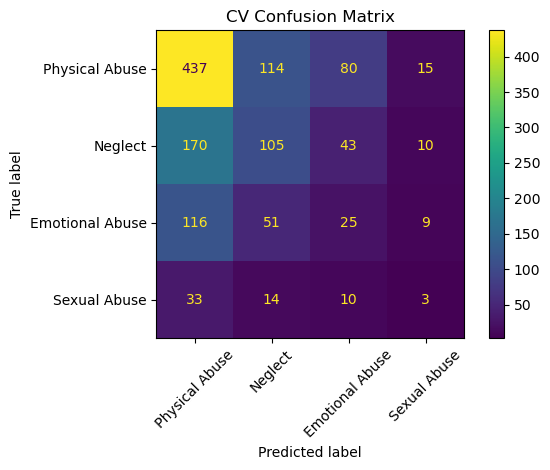

                 precision    recall  f1-score   support

 Physical Abuse       0.58      0.68      0.62       646
        Neglect       0.37      0.32      0.34       328
Emotional Abuse       0.16      0.12      0.14       201
   Sexual Abuse       0.08      0.05      0.06        60

       accuracy                           0.46      1235
      macro avg       0.30      0.29      0.29      1235
   weighted avg       0.43      0.46      0.44      1235



In [23]:
y_pred_cv = cross_val_predict(pipe, X, y, cv=cv, n_jobs=-1)

cm = confusion_matrix(y, y_pred_cv, labels=ABUSE_LABELS)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ABUSE_LABELS)
disp.plot(xticks_rotation=45)
plt.title('CV Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y, y_pred_cv, labels=ABUSE_LABELS))

### Holdout fit + permutation importance (by original columns)

Holdout macro-F1: 0.35200962947456566
Holdout balanced acc: 0.3485905567300916


age                     0.062809
sex                     0.031106
occlusalRelationship    0.029000
OralCleanStatus         0.024063
needTOBEtreated         0.022223
Healthy_Rate            0.021961
gingivitis              0.020747
UTN_Score               0.011101
Baby_DMFT               0.008899
Care_Index              0.003747
habits                  0.000918
Perm_DMFT               0.000814
dtype: float64

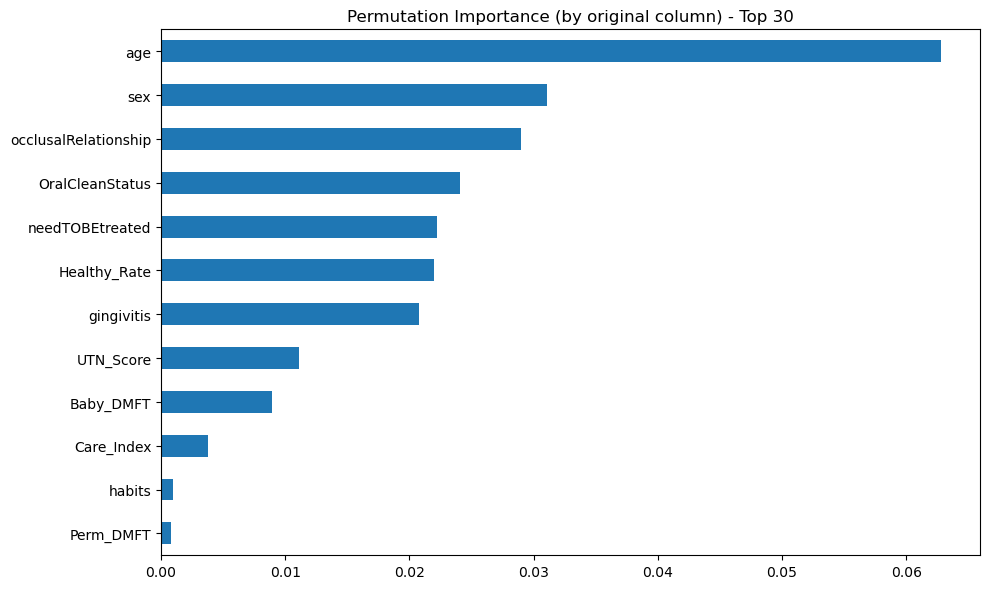

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)

print('Holdout macro-F1:', f1_score(y_test, y_hat, average='macro'))
print('Holdout balanced acc:', balanced_accuracy_score(y_test, y_hat))

pfi = permutation_importance(
    pipe,
    X_test,
    y_test,
    n_repeats=20,
    random_state=0,
    scoring='f1_macro',
    n_jobs=-1
)

imp = pd.Series(pfi.importances_mean, index=X_test.columns).sort_values(ascending=False)
display(imp.head(30))

# Plot top 30
plt.figure(figsize=(10,6))
imp.head(30).sort_values().plot(kind='barh')
plt.title('Permutation Importance (by original column) - Top 30')
plt.tight_layout()
plt.show()


### SHAP for detailed directionality

In [30]:

import shap
prep = pipe.named_steps['prep']
model = pipe.named_steps['rf']

# sample for speed
X_shap = X_train.sample(n=min(400, len(X_train)), random_state=0)
Xt = prep.transform(X_shap)

if hasattr(Xt, 'toarray'):
    Xt_dense = Xt.toarray()
else:
    Xt_dense = np.asarray(Xt)

try:
    feat_names = prep.get_feature_names_out()
except Exception:
    feat_names = None

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xt_dense)

# multiclass: list of arrays
for i, cls in enumerate(model.classes_):
    shap.summary_plot(shap_values[i], Xt_dense, feature_names=feat_names, show=True, max_display=25)
    plt.title(f'SHAP summary - class: {cls}')
    plt.show()



ModuleNotFoundError: No module named 'shap'

In [ ]:

# ---- 11) FastICA on aggregated numeric indices ----
# ICA is best suited for continuous/numeric indices (not huge one-hot sets).

ica_candidates = [
    'Perm_D', 'Perm_M', 'Perm_F',
    'Baby_d', 'Baby_m', 'Baby_f',
    'Perm_DMFT', 'Baby_DMFT',
    'Perm_DMFT_C0', 'Baby_DMFT_C0',
    'DMFT_Index', 'DMFT_C0',
    'Present_Teeth', 'Present_Perm_Teeth', 'Present_Baby_Teeth',
    'Healthy_Rate', 'C0_Count', 'Care_Index',
    'Trauma_Count', 'RDT_Count', 'UTN_Score',
    'gingivitis_bin', 'need_bin', 'OralCleanStatus_ord',
]

ica_cols = [c for c in ica_candidates if c in df_sub.columns]
print('ICA cols:', len(ica_cols))

if len(ica_cols) < 4:
    raise ValueError('Not enough numeric columns for ICA. Please confirm numeric dental index columns.')

X_ica = df_sub[ica_cols].copy()

# impute + standardize
X_imp = SimpleImputer(strategy='median').fit_transform(X_ica)
X_std = StandardScaler().fit_transform(X_imp)

n_components = 3
try:
    ica = FastICA(n_components=n_components, random_state=0, max_iter=3000, whiten='unit-variance')
except TypeError:
    ica = FastICA(n_components=n_components, random_state=0, max_iter=3000, whiten=True)

S = ica.fit_transform(X_std)  # scores
W = ica.components_           # loadings

loadings = pd.DataFrame(W, columns=ica_cols, index=[f'IC{i+1}' for i in range(n_components)])
display(loadings)


In [ ]:

# ---- 12) Add ICA scores to dataframe and compare by abuse group ----

df_ica = df_sub.copy()
for i in range(n_components):
    df_ica[f'IC{i+1}'] = S[:, i]

# Boxplots
for i in range(n_components):
    col = f'IC{i+1}'
    ax = df_ica.boxplot(column=col, by='abuse', grid=False, figsize=(8,5))
    plt.title(f'ICA score by abuse group: {col}')
    plt.suptitle('')
    plt.xlabel('abuse')
    plt.ylabel(f'{col} score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
# ---- 13) (Optional) Age/Sex-adjusted group differences for ICA scores ----
# Requires statsmodels and columns: age, sex

if HAVE_STATSMODELS and ('age' in df_ica.columns) and ('sex' in df_ica.columns):
    for i in range(n_components):
        col = f'IC{i+1}'
        formula = f"{col} ~ C(abuse) + age + C(sex)"
        model = smf.ols(formula, data=df_ica).fit(cov_type='HC3')
        print('\n' + '='*80)
        print('Model:', formula)
        print(model.summary())
else:
    print('Skipped (need statsmodels + age + sex).')


In [ ]:

# ---- 14) Save outputs (optional) ----
OUTDIR = 'ml_outputs_notebook'
os.makedirs(OUTDIR, exist_ok=True)

cv_summary.to_csv(os.path.join(OUTDIR, 'cv_metrics_summary.csv'))
imp.to_csv(os.path.join(OUTDIR, 'permutation_importance_by_column.csv'))
loadings.to_csv(os.path.join(OUTDIR, 'ica_components_loadings.csv'))
df_ica.to_csv(os.path.join(OUTDIR, 'ica_scores_added.csv'), index=False)

print('Saved to:', OUTDIR)
